# Deep Neural Network from scratch : Cat Classifier

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

#np.random.seed(1)

In [2]:
def sigmoid(z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    a= 1/(1+np.exp(-z))
    cache=z
    return a,cache

def relu(z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    a= np.maximum(0,z)
    cache=z
    return a,cache

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    z=cache
    s = 1/(1+np.exp(-z))
    dz=dA*s*(1-s)
    return dz

def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    z=cache
    dz=np.array(dA,copy=True)
    dz[z<=0]=0
    return dz

In [76]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    #np.random.seed(3)
    parameters={}
    L=len(layer_dims)
    
    for i in range(1,L):
        parameters['W'+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/layer_dims[i-1])
        parameters['b'+str(i)]= np.zeros((layer_dims[i],1))
        
    return parameters

In [4]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    #print('W:',W.shape,'  A:',A.shape)
    z=np.dot(W,A)+b
    cache=(A,W,b)
    return z,cache

In [5]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    z,linear_cache=linear_forward(A_prev,W,b)
    #print('z',z.shape)
    if activation=="sigmoid":
        a,activation_cache=sigmoid(z)
    if activation=="relu":
        a,activation_cache=relu(z)
    cache=(linear_cache,activation_cache)
    #print('a',a.shape)
    return a,cache

In [6]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """
    
    caches=[]
    tot_layers=len(parameters)//2
    A=X
    for i in range(1,tot_layers):
        A_prev=A
        A,cache=linear_activation_forward(A_prev,parameters['W'+str(i)],parameters['b'+str(i)],'relu')
        caches.append(cache)
    
    AL,cache=linear_activation_forward(A,parameters['W'+str(i+1)],parameters['b'+str(i+1)],'sigmoid')
    caches.append(cache)
    #print(AL.shape)
    return AL,caches

In [7]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m=Y.shape[1]
    cost=np.sum( -Y*np.log(AL) - (1-Y)*np.log(1-AL) )/m
    return cost

In [8]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev,W,b=cache
    m=A_prev.shape[1]
    dw=1/m * np.dot(dZ,A_prev.T)
    db=1/m * np.sum(dZ,axis=1,keepdims=True)
    dA_prev=np.dot(W.T , dZ)
    
    return dA_prev,dw,db

In [9]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    linear_cache,activation_cache=cache
    if activation=="sigmoid":
        dz=sigmoid_backward(dA,activation_cache)
    if activation=="relu":
        dz=relu_backward(dA,activation_cache)
        
    dA_prev,dw,db=linear_backward(dz, linear_cache)
    return dA_prev,dw,db
        

In [10]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1] # Last Layer
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [11]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    ### END CODE HERE ###
    return parameters

In [71]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    #np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
            

    return parameters

In [97]:
def predict(X, parameters):
    
    probs,_= L_model_forward(X, parameters)
    probs=(probs>=0.5)*1
    return probs

In [13]:
def load_data():
    train_data=h5py.File("datasets/train_catvnoncat.h5","r")
    x_train=np.array(train_data["train_set_x"])
    y_train=np.array(train_data["train_set_y"])
    classes=len(train_data["list_classes"])

    test_data=h5py.File("datasets/test_catvnoncat.h5","r")
    x_test=np.array(test_data["test_set_x"])
    y_test=np.array(test_data["test_set_y"])

    y_train,y_test=y_train.reshape((1,-1)),y_test.reshape((1,-1))
    return x_train,y_train,x_test,y_test,classes

In [14]:
X_train,y_train,X_test,y_test,classes=load_data()

In [59]:
print(X_train.shape,y_train.shape)

(209, 64, 64, 3) (1, 209)


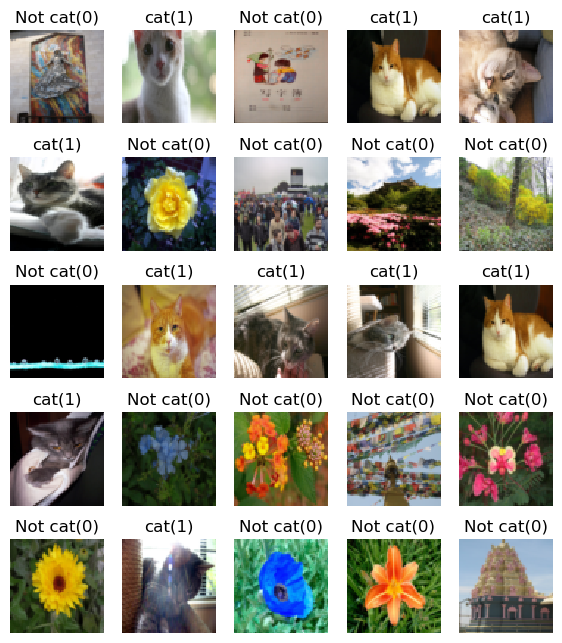

In [63]:
fig,ax=plt.subplots(5,5,figsize=(7,8))
ax=ax.flatten()
for i in range(len(ax.flatten())):
    idx=np.random.randint(0,len(X_train))
    ax[i].imshow(X_train[idx])
    ax[i].set_title("cat(1)" if str(y_train[0,idx])=="1" else "Not cat(0)")
    ax[i].set_axis_off()

In [62]:
X_train_norm=X_train/255
X_test_norm=X_test/255

X_train_norm=X_train_norm.reshape((X_train_norm.shape[0],-1)).T
X_test_norm=X_test_norm.reshape((X_test_norm.shape[0],-1)).T

print(X_train_norm.shape,X_test_norm.shape)

(12288, 209) (12288, 50)


In [77]:
#each example has 64*64*3=12288 pixels
layers_dims=(X_train_norm.shape[0],20,7,5,1)

Cost after iteration 0: 0.704034
Cost after iteration 100: 0.532234
Cost after iteration 200: 0.441235
Cost after iteration 300: 0.365744
Cost after iteration 400: 0.297916
Cost after iteration 500: 0.251033
Cost after iteration 600: 0.170794
Cost after iteration 700: 0.121145
Cost after iteration 800: 0.084211
Cost after iteration 900: 0.053767
Cost after iteration 1000: 0.038221
Cost after iteration 1100: 0.028996
Cost after iteration 1200: 0.022726
Cost after iteration 1300: 0.018268
Cost after iteration 1400: 0.015059
Cost after iteration 1500: 0.012763
Cost after iteration 1600: 0.010934
Cost after iteration 1700: 0.009534
Cost after iteration 1800: 0.008374
Cost after iteration 1900: 0.007441
Cost after iteration 2000: 0.006638
Cost after iteration 2100: 0.005985
Cost after iteration 2200: 0.005427
Cost after iteration 2300: 0.004954
Cost after iteration 2400: 0.004551
Cost after iteration 2500: 0.004200
Cost after iteration 2600: 0.003896
Cost after iteration 2700: 0.003625
Cost

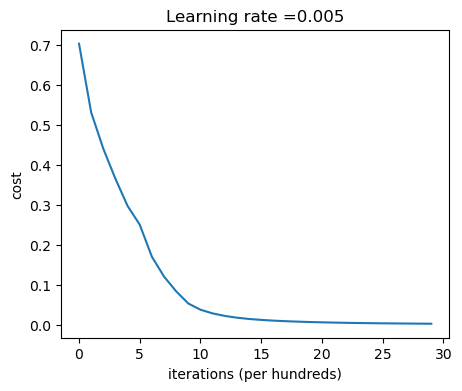

In [80]:
parameters=L_layer_model(X_train_norm, y_train, layers_dims, learning_rate = 0.005, num_iterations = 3000, print_cost=True)

In [101]:
y_train_pred=predict(X_train_norm,parameters)
y_test_pred=predict(X_test_norm,parameters)

In [106]:
print("Training Accuracy: ",np.mean(y_train==y_train_pred)*100,'%')
print("Test Accuracy: ",np.mean(y_test==y_test_pred)*100,'%')

Training Accuracy:  100.0 %
Test Accuracy:  76.0 %


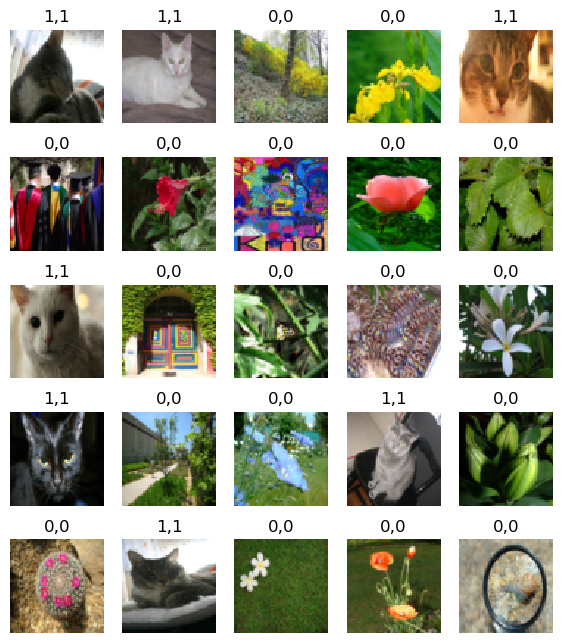

In [111]:
fig,ax=plt.subplots(5,5,figsize=(7,8))
ax=ax.flatten()
plt.title("Actual,predicted")
for i in range(len(ax.flatten())):
    idx=np.random.randint(0,len(X_train))
    ax[i].imshow(X_train[idx])
    ax[i].set_title(str(y_train[0,idx])+','+str(y_train_pred[0,idx]))
    ax[i].set_axis_off()

## Wrong Predictions

In [121]:
#Wrong predictions
wrong_pred_idx=np.where(y_test_pred!=y_test)[1]
print(wrong_pred_idx, wrong_pred_idx.shape)

[ 5  6 13 18 19 26 28 29 34 44 45 46] (12,)


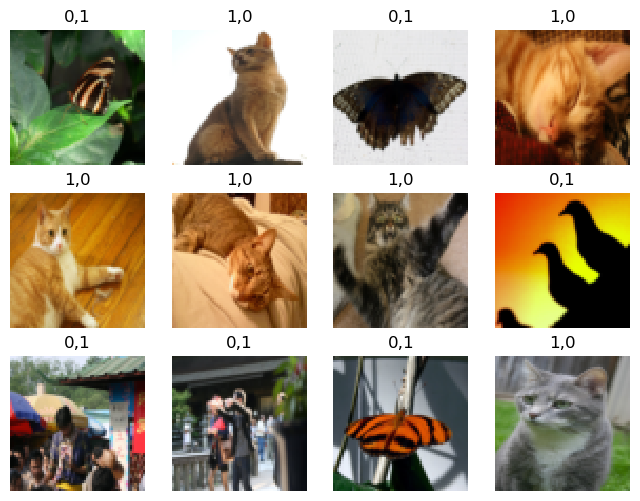

In [133]:
fig,ax=plt.subplots(3,4,figsize=(8,6))
ax=ax.flatten()
plt.title("Actual,predicted")
for i in range(len(ax.flatten())):
    idx=wrong_pred_idx[i]
    ax[i].imshow(X_test[idx])
    ax[i].set_title(str(y_test[0,idx])+','+str(y_test_pred[0,idx]))
    ax[i].set_axis_off()